In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import shuffle
from river import stream, base, compose, preprocessing, metrics, drift, tree
from datetime import datetime
from collections import Counter

In [3]:
df = pd.read_csv('CICIoMT2024/Test.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612117 entries, 0 to 1612116
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Header_Length    1612117 non-null  float64
 1   Protocol Type    1612117 non-null  float64
 2   Duration         1612117 non-null  float64
 3   Rate             1612117 non-null  float64
 4   Srate            1612117 non-null  float64
 5   Drate            1612117 non-null  float64
 6   fin_flag_number  1612117 non-null  float64
 7   syn_flag_number  1612117 non-null  float64
 8   rst_flag_number  1612117 non-null  float64
 9   psh_flag_number  1612117 non-null  float64
 10  ack_flag_number  1612117 non-null  float64
 11  ece_flag_number  1612117 non-null  float64
 12  cwr_flag_number  1612117 non-null  float64
 13  ack_count        1612117 non-null  float64
 14  syn_count        1612117 non-null  float64
 15  fin_count        1612117 non-null  float64
 16  rst_count        1

In [5]:
print(df['Label'].value_counts())

Label
DDoS-UDP              362070
DDoS-ICMP             349698
DDoS-TCP              182597
DDoS-SYN              172397
DoS-UDP               137553
DoS-SYN                98595
DoS-ICMP               98432
DoS-TCP                82096
DDoS-Connect_Flood     41916
Benign                 37607
Port_Scan              20921
DoS-Publish_Flood       8505
DDoS-Publish_Flood      8416
OS_Scan                 3495
DoS-Connect_Flood       3131
Malformed_Data          1747
ARP_Spoofing            1744
VulScan                 1011
Ping_Sweep               186
Name: count, dtype: int64


In [6]:
# Replace all values in 'Label' column with 'Attack', except 'Benign'
df.loc[df['Label'] != 'Benign', 'Label'] = 'Attack'

In [7]:
print(df['Label'].value_counts())

Label
Attack    1574510
Benign      37607
Name: count, dtype: int64


# Online Learning Model

In [8]:
# Preprocess
X = df.drop(columns=['Label'])  
y = df['Label']

X, y = shuffle(X, y, random_state=42)

# Simulate data streaming
dataset = stream.iter_pandas(X, y)

In [9]:
# Online Leveraging Bagging classifier
class LeveragingBaggingClassifier(base.Ensemble, base.Classifier):
    
    def __init__(self, base_estimator, n_estimators: int = 10, lambda_value: float = 6.0, seed: int = None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.lambda_value = lambda_value
        self.seed = seed
        self._rng = random.Random(seed)
        self.learners = [base_estimator() for _ in range(n_estimators)]
    
    def learn_one(self, x: dict, y) -> "LeveragingBaggingClassifier":
        """Update each base learner using Poisson(lambda_value) sampling"""
        for learner in self.learners:
            # Draw the number of updates from a Poisson distribution with mean lambda_value
            k = np.random.poisson(self.lambda_value)
            for _ in range(k):
                learner.learn_one(x, y)
        return self
    
    def predict_proba_one(self, x: dict) -> dict:
        """Aggregate probability predictions from all base learners"""
        votes = {}
        for learner in self.learners:
            proba = learner.predict_proba_one(x)
            for label, p in proba.items():
                votes[label] = votes.get(label, 0) + p
        # Average the votes over the number of learners
        n = len(self.learners)
        if n > 0:
            for label in votes:
                votes[label] /= n
        return votes

    def predict_one(self, x: dict):
        """Return the class with the highest aggregated probability"""
        proba = self.predict_proba_one(x)
        if not proba:
            return None
        return max(proba, key=proba.get)

    def __iter__(self):
        """Allow iteration over the base learners"""
        return iter(self.learners)

In [10]:
# Define a factory function for the base learner
def create_hoeffding_tree():
    # Customize parameters as needed
    return tree.HoeffdingTreeClassifier(grace_period=30, delta=0.01)

# Instantiate the Leveraging Bagging classifier using the base learner factory
leveraging_bagging = LeveragingBaggingClassifier(
    base_estimator=create_hoeffding_tree,
    n_estimators=10,
    lambda_value=6.0,
    seed=42
)

# Build pipeline by adding a preprocessing step
model = compose.Pipeline(
    ('scaler', preprocessing.StandardScaler()),
    ('classifier', leveraging_bagging)
)

In [11]:
# Define Metrics
metric_accuracy = metrics.Accuracy()
metric_precision = metrics.WeightedPrecision()
metric_recall = metrics.WeightedRecall()
metric_f1 = metrics.WeightedF1()

In [12]:
# Add Drift Detector
drift_detector = drift.PageHinkley()

# Timing and visualization variables
start_time = time.time()
total_time = 0
drift_time_total = 0
metrics_time_total = 0
instance_count = 0
drift_events = []
processing_times = []
drift_time_per_instance = []
metrics_time_per_instance = []
metric_logs = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

In [13]:
# Train, Evaluate, and Detect Drift
for x, y_true in dataset:
    instance_start = time.time()

    # Prediction and learning
    y_pred = model.predict_one(x)
    model.learn_one(x, y_true)

    # Time spent on metrics
    metrics_start = time.time()
    metric_accuracy.update(y_true, y_pred)
    metric_precision.update(y_true, y_pred)
    metric_recall.update(y_true, y_pred)
    metric_f1.update(y_true, y_pred)
    metrics_time_total += time.time() - metrics_start
    metrics_time_per_instance.append(time.time() - metrics_start) ###

    # Log metrics
    metric_logs['accuracy'].append(metric_accuracy.get())
    metric_logs['precision'].append(metric_precision.get())
    metric_logs['recall'].append(metric_recall.get())
    metric_logs['f1_score'].append(metric_f1.get())

    # Drift detection
    drift_start = time.time()
    drift_detector.update(int(y_pred != y_true))
    if drift_detector.drift_detected:
        detection_time = datetime.now()
        drift_events.append(instance_count)
        print(f"\nDrift detected at instance: {instance_count}")
        print(f"Detection Time: {detection_time}\n")
    drift_elapsed = time.time() - drift_start
    drift_time_total += drift_elapsed
    drift_time_per_instance.append(drift_elapsed) ###

    # Update cumulative time
    instance_time = time.time() - instance_start
    total_time += instance_time
    processing_times.append(instance_time)
    instance_count += 1

    if instance_count % 100 == 0:
        print(f"Processed {instance_count}/{len(X)} instances")

# Summary of execution times
end_time = time.time()

Processed 100/1612117 instances
Processed 200/1612117 instances
Processed 300/1612117 instances
Processed 400/1612117 instances
Processed 500/1612117 instances
Processed 600/1612117 instances
Processed 700/1612117 instances
Processed 800/1612117 instances
Processed 900/1612117 instances
Processed 1000/1612117 instances
Processed 1100/1612117 instances
Processed 1200/1612117 instances
Processed 1300/1612117 instances
Processed 1400/1612117 instances
Processed 1500/1612117 instances
Processed 1600/1612117 instances
Processed 1700/1612117 instances
Processed 1800/1612117 instances
Processed 1900/1612117 instances
Processed 2000/1612117 instances
Processed 2100/1612117 instances
Processed 2200/1612117 instances
Processed 2300/1612117 instances
Processed 2400/1612117 instances
Processed 2500/1612117 instances
Processed 2600/1612117 instances
Processed 2700/1612117 instances
Processed 2800/1612117 instances
Processed 2900/1612117 instances
Processed 3000/1612117 instances
Processed 3100/1612

In [14]:
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")
print(f"Total time spent on drift detection: {drift_time_total:.2f} seconds")
print(f"Total time spent updating metrics: {metrics_time_total:.2f} seconds")
print(f"Total drifts detected: {len(drift_events)}")

Total Execution Time: 15696.72 seconds
Total time spent on drift detection: 5.71 seconds
Total time spent updating metrics: 7.91 seconds
Total drifts detected: 0


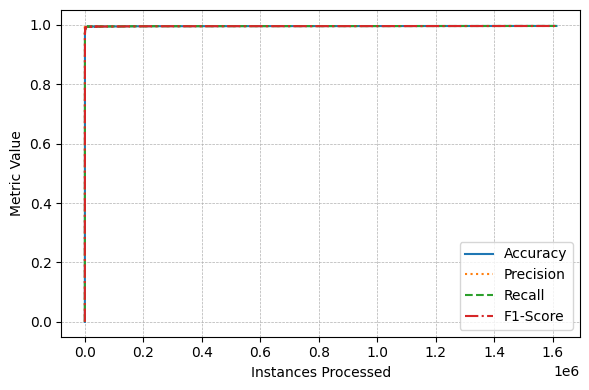

In [15]:
instances_processed = list(range(1, len(metric_logs['accuracy']) + 1))

# Create a plot
plt.figure(figsize=(6, 4))
plt.plot(instances_processed, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances_processed, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances_processed, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances_processed, metric_logs['f1_score'], label='F1-Score', linestyle='-.')

# Add drift events without duplicating the label
for i, drift_event in enumerate(drift_events):
    plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
#plt.title('Performance Metrics Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')

# Save or show the plot
plt.savefig('PM15-1.png', dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

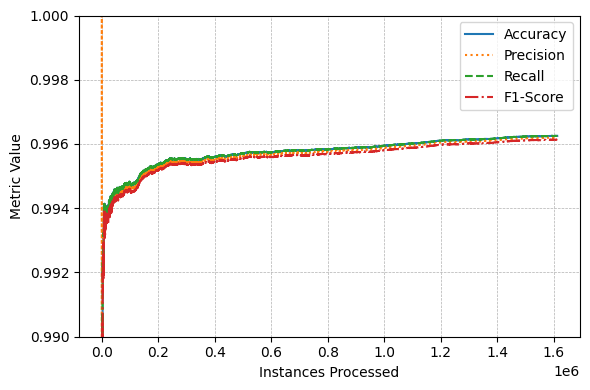

In [16]:
instances_processed = list(range(1, len(metric_logs['accuracy']) + 1))

# Create a plot
plt.figure(figsize=(6, 4))
plt.plot(instances_processed, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances_processed, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances_processed, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances_processed, metric_logs['f1_score'], label='F1-Score', linestyle='-.')

# Add drift events without duplicating the label
for i, drift_event in enumerate(drift_events):
    plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
#plt.title('Performance Metrics Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')

plt.ylim([0.99, 1])

# Save or show the plot
plt.savefig('PM15-2.png', dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

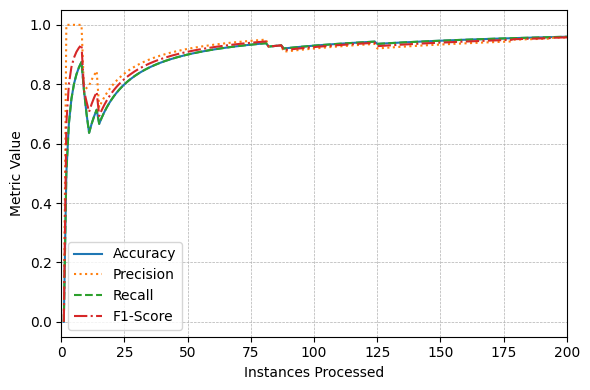

In [17]:
instances_processed = list(range(1, len(metric_logs['accuracy']) + 1))

# Create a plot
plt.figure(figsize=(6, 4))
plt.plot(instances_processed, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances_processed, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances_processed, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances_processed, metric_logs['f1_score'], label='F1-Score', linestyle='-.')

# Add drift events without duplicating the label
for i, drift_event in enumerate(drift_events):
    plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
#plt.title('Performance Metrics Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')

plt.xlim([0, 200])

# Save or show the plot
plt.savefig('PM15-3.png', dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

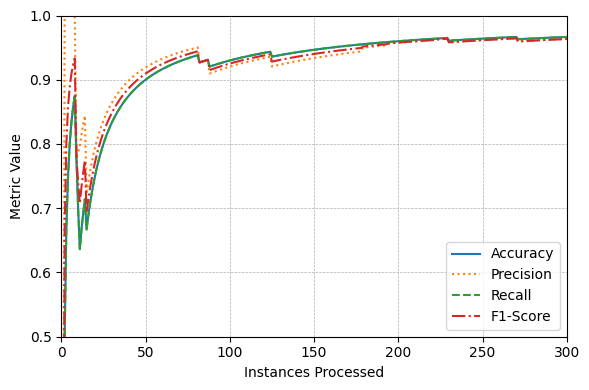

In [18]:
instances_processed = list(range(1, len(metric_logs['accuracy']) + 1))

# Create a plot
plt.figure(figsize=(6, 4))
plt.plot(instances_processed, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances_processed, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances_processed, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances_processed, metric_logs['f1_score'], label='F1-Score', linestyle='-.')

# Add drift events without duplicating the label
for i, drift_event in enumerate(drift_events):
    plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
#plt.title('Performance Metrics Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')

plt.xlim([0, 300])
plt.ylim([0.5, 1])

# Save or show the plot
plt.savefig('PM15-4.png', dpi=1000, bbox_inches='tight')
plt.tight_layout()
plt.show()

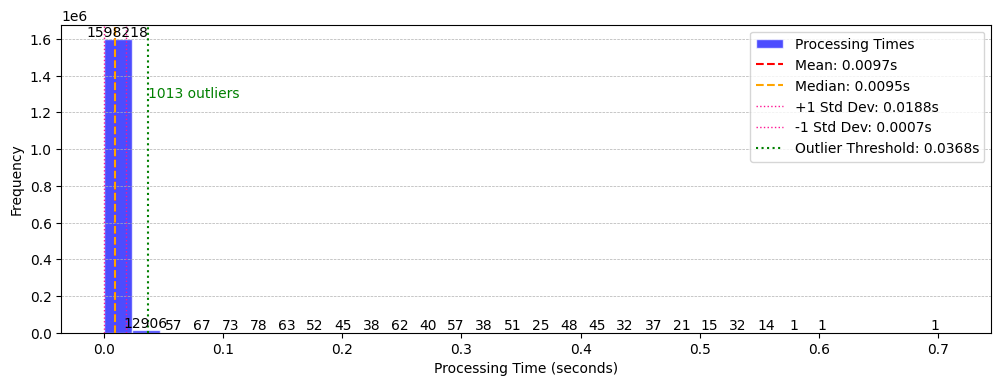

In [19]:
# Compute descriptive statistics
mean_time = np.mean(processing_times)
median_time = np.median(processing_times)
std_dev_time = np.std(processing_times)
outlier_threshold = mean_time + 3 * std_dev_time  # Define outliers as 3 standard deviations above the mean
outlier_counts = sum(time > outlier_threshold for time in processing_times)

# Plot histogram
plt.figure(figsize=(12, 4))
counts, bins, bars = plt.hist(processing_times, bins=30, edgecolor='white', color='blue', alpha=0.7, label='Processing Times')

# Add vertical lines for statistics
plt.axvline(mean_time, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_time:.4f}s')
plt.axvline(median_time, color='orange', linestyle='dashed', linewidth=1.5, label=f'Median: {median_time:.4f}s')
plt.axvline(mean_time + std_dev_time, color='deeppink', linestyle='dotted', linewidth=1, label=f'+1 Std Dev: {mean_time + std_dev_time:.4f}s')
plt.axvline(mean_time - std_dev_time, color='deeppink', linestyle='dotted', linewidth=1, label=f'-1 Std Dev: {mean_time - std_dev_time:.4f}s')
plt.axvline(outlier_threshold, color='green', linestyle='dotted', linewidth=1.5, label=f'Outlier Threshold: {outlier_threshold:.4f}s')

# Add annotations to the histogram bars
for count, bin_edge in zip(counts, bins):
    if count > 0:  # Avoid clutter for empty bins
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Annotate outliers
plt.text(outlier_threshold, max(counts) * 0.8, f'{outlier_counts} outliers', color='green', ha='left')

# Add labels, legend, and title
plt.xlabel('Processing Time (seconds)')
plt.ylabel('Frequency')
#plt.title('Enhanced Distribution of Instance Processing Times')
# Add grid and legend
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.savefig('PT15.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

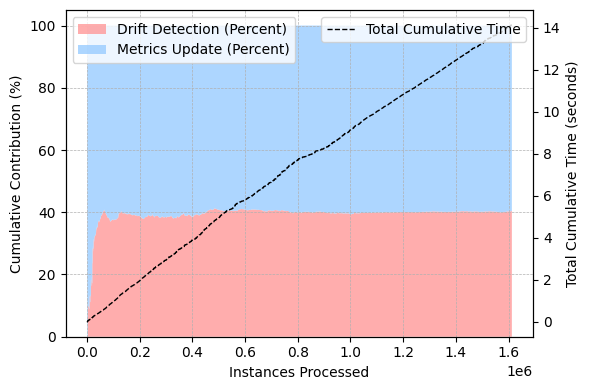

In [20]:
# Calculate cumulative sums
cumulative_drift_time = np.cumsum(drift_time_per_instance)
cumulative_metrics_time = np.cumsum(metrics_time_per_instance)
cumulative_total_time = cumulative_drift_time + cumulative_metrics_time
processing_time = list(range(len(cumulative_drift_time)))

epsilon = 1e-10  # A small value to avoid division by zero

# Safely handle division by zero using NumPy
cumulative_total_time = np.where(cumulative_total_time == 0, epsilon, cumulative_total_time)

# Convert to percentages
cumulative_drift_percent = cumulative_drift_time / cumulative_total_time * 100
cumulative_metrics_percent = cumulative_metrics_time / cumulative_total_time * 100

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(6, 4))

# Primary Y-Axis (percentages)
ax1.stackplot(processing_time, cumulative_drift_percent, cumulative_metrics_percent,
              labels=['Drift Detection (Percent)', 'Metrics Update (Percent)'],
              colors=['#FF9999', '#99CCFF'], alpha=0.8)
ax1.set_xlabel('Instances Processed')
ax1.set_ylabel('Cumulative Contribution (%)')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Secondary Y-Axis (total time)
ax2 = ax1.twinx()
ax2.plot(processing_time, cumulative_total_time, color='black', linestyle='--', linewidth=1, label='Total Cumulative Time')
ax2.set_ylabel('Total Cumulative Time (seconds)')
ax2.legend(loc='upper right')

# Annotate drift events
for i, drift_instance in enumerate(drift_events):
    ax1.axvline(drift_instance, color='blue', linestyle='dotted', linewidth=1)
    ax1.text(drift_instance, 2, f'Drift - {drift_instance}', rotation=90, color='blue')

# Add title and save
#plt.title('Enhanced Cumulative Time Analysis with Dual Y-Axis')
plt.tight_layout()
plt.savefig('CT15.png', dpi=1000, bbox_inches='tight')
plt.show()

In [21]:
if drift_events:
    # Extract pre-drift and post-drift accuracies for each drift event
    pre_drift_accuracy = [metric_logs['accuracy'][i-1] for i in drift_events]
    post_drift_accuracy = [metric_logs['accuracy'][i] for i in drift_events]
    drift_labels = [f'Drift {i+1}' for i in range(len(drift_events))]
    
    # Sort drift events by the magnitude of accuracy change
    sorted_indices = sorted(range(len(drift_events)), key=lambda i: abs(pre_drift_accuracy[i] - post_drift_accuracy[i]), reverse=True)
    pre_drift_accuracy = [pre_drift_accuracy[i] for i in sorted_indices]
    post_drift_accuracy = [post_drift_accuracy[i] for i in sorted_indices]
    drift_labels = [drift_labels[i] for i in sorted_indices]
    
    x = range(len(drift_events))  # X-axis positions for drift events

    # Set up the figure
    plt.figure(figsize=(6, 5))
    
    # Bar width for side-by-side comparison
    bar_width = 0.4
    
    # Plot pre-drift and post-drift accuracies
    plt.bar(x, pre_drift_accuracy, width=bar_width, label='Pre-Drift Accuracy', color='#1f77b4', alpha=0.8)
    plt.bar([i + bar_width for i in x], post_drift_accuracy, width=bar_width, label='Post-Drift Accuracy', color='#ff7f0e', alpha=0.8)
    
    # Annotate bars with their accuracy values
    for i, (pre, post) in enumerate(zip(pre_drift_accuracy, post_drift_accuracy)):
        plt.text(i, pre, f'{pre:.2f}', ha='center', va='bottom', color='black')
        plt.text(i + bar_width, post, f'{post:.2f}', ha='center', va='bottom', color='black')

        # Add percentage change annotation
        pct_change = ((post - pre) / pre) * 100 if pre > 0 else 0
        plt.text(i + bar_width / 2, max(pre, post) + 0.009, f'{pct_change:+.6f}%', ha='center', color='green' if pct_change > 0 else 'red')
    
    # Add descriptive x-axis labels for drift events
    plt.xticks([i + bar_width / 2 for i in x], drift_labels)

    # Calculate and plot the average accuracy as a horizontal line
    avg_accuracy = sum(metric_logs['accuracy']) / len(metric_logs['accuracy'])
    plt.axhline(avg_accuracy, color='red', linestyle='--', linewidth=1, label=f'Average Accuracy: {avg_accuracy:.2f}')

    # Add labels, title, grid, and legend
    plt.xlabel('Drift Event')
    plt.ylabel('Accuracy')
    #plt.title('Model Accuracy Before and After Drift (with Percentage Changes)')
    plt.ylim(0, 1)  # Adjust y-axis limits for better focus
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Save the chart as a high-resolution image (optional)
    plt.savefig('MA15.png', dpi=1000, bbox_inches='tight')

    # Display the plot
    plt.show()
else:
    print("No drift events detected.")

No drift events detected.


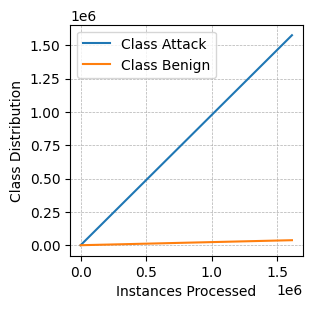

In [22]:
# Initialize class distribution dictionary with cumulative sums
class_distribution = {cls: [0] for cls in set(y)}  # Start with 0 for all classes

# Update cumulative counts for each class
for i, cls in enumerate(y):
    for key in class_distribution:
        class_distribution[key].append(class_distribution[key][-1] + (1 if cls == key else 0))

# Remove the initial zero added to each class (optional for clarity)
for key in class_distribution:
    class_distribution[key] = class_distribution[key][1:]

plt.figure(figsize=(3, 3))
for cls, counts in class_distribution.items():
    plt.plot(instances_processed, counts, label=f'Class {cls}')
plt.xlabel('Instances Processed')
plt.ylabel('Class Distribution')
#plt.title('Class Distribution Over Time')
# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.savefig('CD15.png', dpi=1000, bbox_inches='tight')
plt.show()

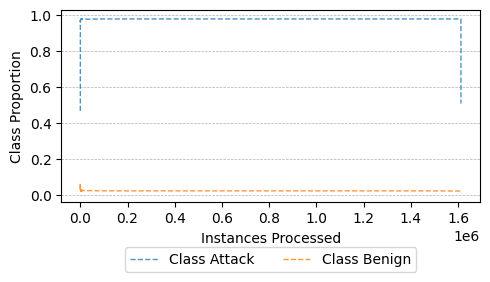

In [23]:
# Smooth function
def smooth(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Initialize class distribution dictionary
class_distribution = {cls: [] for cls in set(y)}

# Initialize running counter for each class
running_counts = Counter()

# Generate instances_processed to match the length of y
instances_processed = list(range(1, len(y) + 1))

# Calculate cumulative counts efficiently
for i, label in enumerate(y):
    running_counts[label] += 1  # Update count for the current label
    for cls in class_distribution.keys():
        class_distribution[cls].append(running_counts[cls])

# Normalize cumulative counts to proportions
total_instances = np.arange(1, len(y) + 1)  # Matches the length of instances_processed
normalized_distribution = {cls: np.array(counts) / total_instances for cls, counts in class_distribution.items()}

# Smooth the data
smoothed_distribution = {cls: smooth(proportions, window_size=50) for cls, proportions in normalized_distribution.items()}

# Plot class distribution over time (full view)
plt.figure(figsize=(5, 3))
for cls, proportions in smoothed_distribution.items():
    plt.plot(instances_processed, proportions, label=f'Class {cls}', linewidth=1, linestyle='--', alpha=0.8)
    
# Add drift markers
for drift_event in drift_events:
    plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if drift_event == drift_events[0] else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed')
plt.ylabel('Class Proportion')
#plt.title('Smoothed Normalized Class Distribution Over Time with Drift Markers')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.tight_layout()
plt.savefig('SD15.png', dpi=1000, bbox_inches='tight')
plt.show()

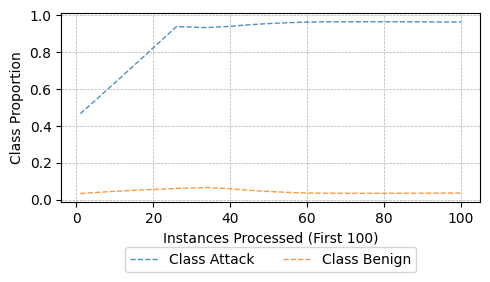

In [24]:
# Zoomed-in view for the first 100 instances
plt.figure(figsize=(5, 3))
for cls, proportions in smoothed_distribution.items():
    plt.plot(instances_processed[:100], proportions[:100], label=f'Class {cls}', linewidth=1, linestyle='--', alpha=0.8)

# Add drift markers (only for zoomed-in range)
for drift_event in drift_events:
    if drift_event <= 100:
        plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if drift_event == drift_events[0] else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed (First 100)')
plt.ylabel('Class Proportion')
#plt.title('Zoomed-In Class Distribution (First 100 Instances) with Drift Markers')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.tight_layout()
plt.savefig('ZD15-1.png', dpi=1000, bbox_inches='tight')
plt.show()

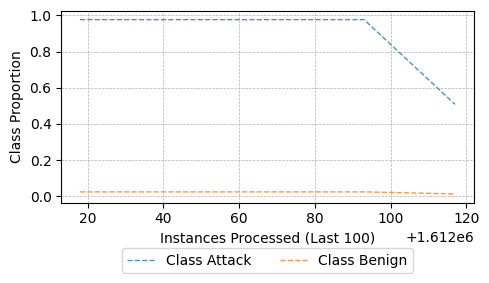

In [25]:
# Zoomed-in view for the last 100 instances
plt.figure(figsize=(5, 3))
for cls, proportions in smoothed_distribution.items():
    plt.plot(instances_processed[1612017:], proportions[1612017:], label=f'Class {cls}', linewidth=1, linestyle='--', alpha=0.8)

# Add drift markers (only for zoomed-in range)
for drift_event in drift_events:
    if drift_event >= 1612017:
        plt.axvline(x=drift_event, color='blue', linestyle=':', linewidth=1, label='Drift Event' if drift_event == drift_events[0] else "")

# Add labels, title, grid, and legend
plt.xlabel('Instances Processed (Last 100)')
plt.ylabel('Class Proportion')
#plt.title('Zoomed-In Class Distribution (Last 100 Instances) with Drift Markers')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.tight_layout()
plt.savefig('ZD15-2.png', dpi=1000, bbox_inches='tight')
plt.show()

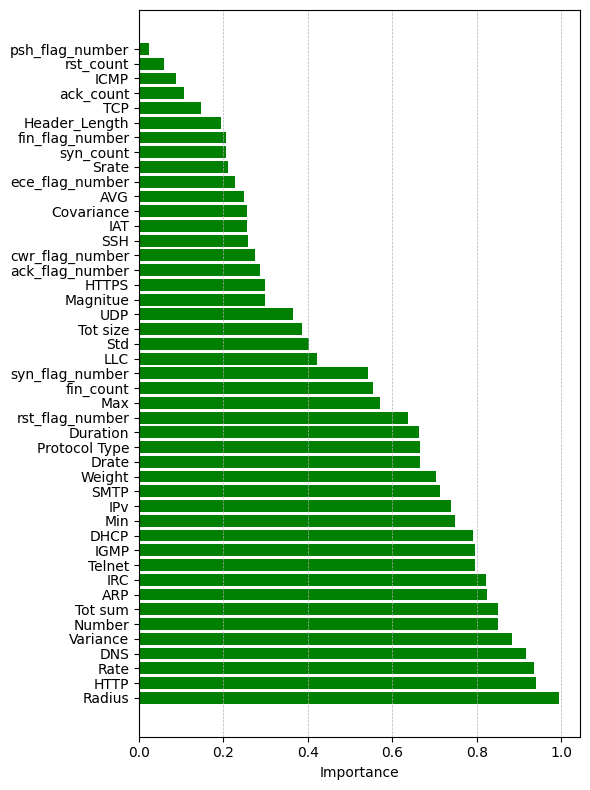

In [26]:
# Simulate feature importances as uniform values for demonstration purposes
feature_importances = np.random.uniform(0, 1, len(X.columns))  # Replace with your actual method if available
feature_names = X.columns  # Assuming X is your DataFrame with feature names

# Sort feature importances and corresponding feature names in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importances as a horizontal bar chart
plt.figure(figsize=(6, 8))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, color='green')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importance')
#plt.title('Feature Importance (Sorted)')
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('FI15.png', dpi=1000, bbox_inches='tight')
plt.show()

In [27]:
# Print Final Metrics
print(f"Accuracy: {metric_accuracy.get():.4f}")
print(f"Precision: {metric_precision.get():.4f}")
print(f"Recall: {metric_recall.get():.4f}")
print(f"F1-Score: {metric_f1.get():.4f}")

Accuracy: 0.9963
Precision: 0.9962
Recall: 0.9963
F1-Score: 0.9961
